## Asynchronous Advantage Actor-Critic (A3C)
The aim of this notebook is to present a distributed A3C implementation with a centralised controller that stores logs and can send instructions to different processes. We use Ray with ZMQ sockets to manually manage interprocess communication.

The diagram below illustrates the setup, as well as how the different components communicate asynchronously.

<img src="https://i.imgur.com/IYeMfOR.png" 
     align="center" 
     width="700"
     style="padding: 20px;" />

#### A3C Algorithm:

1. **Initialise Workers**: Set up each worker as an independent process with its own environment instance.
2. **Initialise Global Network**: Set up a central network that will receive gradients from workers.
3. **Distribute Initial Parameters**: Send the global network parameters to each worker to begin training.

**Repeat until convergence**:

4. **Asynchronous Rollouts**: Each worker independently performs rollouts in its environment.
5. **Gradient Computation**: Upon completing a rollout, a worker calculates the gradients of a composite A2C loss with respect to each parameter.
6. **Send Gradients to Global Network**: The worker sends its computed gradients to the global network.
7. **Update Global Network**: The global network updates its parameters using the received gradients.
8. **Distribute Updated Parameters**: Updated model parameters are sent back to the worker that completed its task.
9. **New Worker Rollout**: The worker receives updated parameters and starts a new rollout.

## PyTorch Actor-Critic Network
A simple actor-critic network with no parameter sharing, tanh activation and reduced weight magnitude on the actor output layer.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F

class ActorCriticNetwork(nn.Module):
    "Joint actor and critic neural network with no parameter sharing"
    def __init__(self, obs_dim, action_dim, hidden_dim=64):
        super().__init__()
        
        self.actor = nn.Sequential(
            nn.Linear(obs_dim,  hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, action_dim)
        )
        self.actor[-1].weight.data *= 0.01
        
        self.critic = nn.Sequential(
            nn.Linear(obs_dim,  hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, x):
        return self.actor(x), self.critic(x)

## Worker
Each worker operates asynchronously in its own process. It performs rollouts in its own copy of the environment, performing actions until the environment is done. When done, the worker computes the gradients for the experience it just gathered and sends them to the global network using the req/rep messaging pattern. The worker then waits for the global network to reply with updated model parameters before continuing to perform another rollout.

In [2]:
import numpy as np
import ray
import zmq
import pickle
import copy
import time 

@ray.remote
class Worker:
    def __init__(self, idx, network, env, config):
        self.idx = idx
        self.network = copy.deepcopy(network)
        self.env = env
        self.initialize_sockets(config['reqrep_port'], config['pubsub_port'], config['pushpull_port'])
        self.config = config
        
    def initialize_sockets(self, reqrep_port, pubsub_port, pushpull_port):
        "Initialises sockets used by worker."
        # Reqrep socket, workers send gradients requesting new parameters as a reply
        context = zmq.Context()
        self.req_socket = context.socket(zmq.REQ)
        self.req_socket.connect(f"tcp://127.0.0.1:{reqrep_port}")
        
        # Sub socket receives messages sent by a publisher
        self.sub_socket = context.socket(zmq.SUB) 
        self.sub_socket.setsockopt_string(zmq.SUBSCRIBE, '')  # Accept all messages sent by publisher
        self.sub_socket.connect(f"tcp://127.0.0.1:{pubsub_port}")
        
        # Push socket used to send logs to pull socket
        self.push_socket = context.socket(zmq.PUSH)
        self.push_socket.connect(f"tcp://127.0.0.1:{pushpull_port}")
        
        
    def send_gradients(self, gradients):
        "Sends calculated gradients to global network, blocks until updated model parameters are sent back."
        # Convert gradients to list of numpy arrays
        gradients_numpy = [grad.numpy() for grad in gradients]
        
        # Serialise list of numpy arrays to binary format
        gradients_numpy_serialized = pickle.dumps(gradients_numpy, protocol=pickle.HIGHEST_PROTOCOL)
        
        # Send over reqrep socket
        self.req_socket.send(gradients_numpy_serialized)
            
    def receive_parameters(self):
        "Receieve new parameters from global network, copying to worker. Blocks waiting for a response."
        # Waits for reply over reqrep socket
        new_parameters_serialized = self.req_socket.recv()
        
        # Deserialise parameters back into list of numpy arrays, then convert to torch parameters
        new_parameters_numpy = pickle.loads(new_parameters_serialized)
        new_parameters = [torch.tensor(param, dtype=torch.float32) for param in new_parameters_numpy]
        return new_parameters
    
    def receive_instruction(self):
        "Check sub socket to see if instruction has been published."
        # Check to see if instruction have been sent
        instruction_serialized = False
        try:
            instruction_serialized = self.sub_socket.recv(zmq.DONTWAIT)
        except zmq.Again:
            return None

        # If instruction received, deserialise and return
        if instruction_serialized:
            instruction = pickle.loads(instruction_serialized)
            return instruction
        
    def set_parameters(self, new_parameters):
        "Set worker model parameters to parameters received from global network."
        for param, new_param in zip(self.network.parameters(), new_parameters):
            param.data.copy_(new_param)
            
    def collect_gradients(self):
        "Load provided parameters, perform a rollout, compute gradients and return them with info"
        # Perform rollout
        states, actions, rewards, next_states, dones = zip(*self.rollout())
        
        # Calculate loss and perform backward pass to calculate gradients
        loss = self.calculate_loss(states, actions, rewards, next_states, dones)
        loss.backward()
        
        # Collect gradients from model and convert to list of numpy arrays
        gradients = [param.grad for param in self.network.parameters()]
        return gradients
        
    def send_logs(self):
        "Sends logs from last rollout over push socket."
        logs_serialized = pickle.dumps(self.rollout_info, protocol=pickle.HIGHEST_PROTOCOL)
        self.push_socket.send(logs_serialized)
        
    def select_action(self, state, deterministic=False):
        "Action selection logic from a numpy state"
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            logits = self.network.actor(state_tensor)
            if deterministic:
                return logits.argmax(1).item()
            return torch.distributions.Categorical(logits=logits).sample().item()
        
    def rollout(self):
        "Performs a rollout in environment, taking actions until environment is done."
        self.rollout_info = {'worker_idx': self.idx, 'steps': 0, 'reward': 0.}
        state, _ = self.env.reset()
        done = False
        transitions = []
        while not done:
            action = self.select_action(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            transitions.append((state, action, reward, next_state, done))
            state = next_state
            self.rollout_info['steps'] += 1
            self.rollout_info['reward'] += reward
        return transitions
        
    def calculate_loss(self, states, actions, rewards, next_states, dones):
        "Calculates loss term that combines policy, value and entropy losses"
        states      = torch.tensor(np.array(states),      dtype=torch.float32)
        actions     = torch.tensor(np.array(actions),     dtype=torch.long)
        rewards     = torch.tensor(np.array(rewards),     dtype=torch.float32)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
        dones       = torch.tensor(np.array(dones),       dtype=torch.float32)

        # Network forward pass
        logits, values = self.network(states)
        
        # Rewards-to-go calculation
        with torch.no_grad():
            R = 0.
            rewards_to_go = torch.zeros_like(rewards)
            for i in reversed(range(len(rewards))):
                R = rewards[i] + self.config['gamma'] * R * (1 - dones[i])
                rewards_to_go[i] = R

        # Calculate advantages
        advantages = rewards_to_go - values.squeeze(1).detach()
        
        # Calculate log probilities of actions taken
        distribution = torch.distributions.Categorical(logits=logits)
        log_probs = distribution.log_prob(actions)

        # Policy loss, value loss and entropy bonus
        loss = -(log_probs * advantages).mean() + \
               F.mse_loss(values.squeeze(1), rewards_to_go) + \
               -self.config['beta'] * distribution.entropy().mean()
        return loss
    
    def run(self):
        while True:
            gradients = self.collect_gradients()
            self.send_gradients(gradients)
            new_parameters = self.receive_parameters()
            self.set_parameters(new_parameters)
            self.send_logs()
            instruction = self.receive_instruction()
            if instruction == 'stop':
                break

## Global Network
The global network receives precalculated gradients from workers asynchronously, uses them to update its own model parameters, and replies to the worker with the updated version of the model parameters.

In [3]:
import numpy as np
import ray
import zmq
import pickle
import copy
import torch
import time 

@ray.remote
class GlobalNetwork:
    def __init__(self, network, config):
        self.network = copy.deepcopy(network)
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=config['lr'])
        self.initialize_sockets(config['reqrep_port'], config['pubsub_port'], config['pushpull_port'])
        self.config = config
        
    def initialize_sockets(self, reqrep_port, pubsub_port, pushpull_port):
        "Initialises sockets used by global network."
        # REP socket binds to TCP address and listens for messages from REQ sockets
        context = zmq.Context()
        self.rep_socket = context.socket(zmq.REP)
        self.rep_socket.bind(f"tcp://127.0.0.1:{reqrep_port}")
        
        # Sub socket receives messages sent by a publisher
        self.sub_socket = context.socket(zmq.SUB) 
        self.sub_socket.setsockopt_string(zmq.SUBSCRIBE, '')  # Accept all messages sent by publisher
        self.sub_socket.connect(f"tcp://127.0.0.1:{pubsub_port}")
        
        # Push socket used to send logs to pull socket
        self.push_socket = context.socket(zmq.PUSH)
        self.push_socket.connect(f"tcp://127.0.0.1:{pushpull_port}")
        
    def receive_gradients(self):
        "Receive precomputed gradients from worker."
        # Wait to receive gradients from workers over REP socket
        gradients_numpy_serialized = self.rep_socket.recv()
        
        # Deserialise receieved message and convert gradients to list of torch tensors
        gradients_numpy = pickle.loads(gradients_numpy_serialized)
        gradients = [torch.tensor(grad, dtype=torch.float32) for grad in gradients_numpy]
        return gradients
    
    def receive_instruction(self):
        "Check sub socket to see if instruction has been published."
        # Check to see if instruction have been sent
        instruction_serialized = False
        try:
            instruction_serialized = self.sub_socket.recv(zmq.DONTWAIT)
        except zmq.Again:
            return None

        # If instruction received, deserialise and return
        if instruction_serialized:
            instruction = pickle.loads(instruction_serialized)
            return instruction
        
    def send_parameters(self):
        "Send updated model parameters to worker that just sent gradients."
        # Get model state dict and convert to list of numpy arrays
        state_dict = self.network.state_dict()
        parameters = [param.numpy() for param in state_dict.values()]
        
        # Serialise parameters into binary data and send to worker over REP socket
        parameters_serialized = pickle.dumps(parameters, protocol=pickle.HIGHEST_PROTOCOL)
        self.rep_socket.send(parameters_serialized)
        
    def send_logs(self):
        "Sends a simple log over indicating one update has been performed, over push socket."
        logs_serialized = pickle.dumps({'updates': 1}, protocol=pickle.HIGHEST_PROTOCOL)
        self.push_socket.send(logs_serialized)
    
    def apply_gradients(self, gradients):
        "Set each parameter gradient and perform a learning step."
        for param, grad in zip(self.network.parameters(), gradients):
            param.grad = grad
        self.optimizer.step()
        self.optimizer.zero_grad()
        
    def run(self):
        while True:
            gradients = self.receive_gradients()
            self.apply_gradients(gradients)
            self.send_parameters()
            self.send_logs()
            instruction = self.receive_instruction()
            if instruction == 'stop':
                break

## Controller
The controller class has two main functions:

#### Create logs
Workers and the global network send small dictionaries of log information to the controller, which acts as a centralised hub to store all log information.

#### Send messages to global network and workers
Since the controller is the only component that has access to all the historical training information, it will ultimately make decision on when/how to make changes to the training procedure.

For simplicity in our A3C model, the only message our controller will be able to broadcast to the global network and workers is when to stop training, which we'll achieve using the pub/sub messaging pattern. We'll also use the controller to print some simple logs, but these could just as easily be written to disk to be used with live plot visualisations.

In [4]:
@ray.remote
class Controller:
    def __init__(self, config):
        self.logs = {'updates': 0, 'steps': 0, 'rewards': []}
        self.initialize_sockets(config['pubsub_port'], config['pushpull_port'])
        self.config = config
    
    def initialize_sockets(self, pubsub_port, pushpull_port):
        "Initialises sockets used by controller."
        # PUB socket publishes messages to any connected SUB sockets
        context = zmq.Context()
        self.pub_socket = context.socket(zmq.PUB)
        self.pub_socket.bind(f"tcp://127.0.0.1:{pubsub_port}")
        
        # PULL socket accepts any data sent by push sockets
        self.pull_socket = context.socket(zmq.PULL)
        self.pull_socket.bind(f"tcp://127.0.0.1:{pushpull_port}")

    def publish_instruction(self, instruction):
        "Publishes instruction to any subscribed sockets."
        instruction_serialized = pickle.dumps(instruction)
        self.pub_socket.send(instruction_serialized)
    
    def receive_logs(self):
        "Checks pull socket to see if new logs have been sent. If they have, update current logs."
        new_logs_serialized = self.pull_socket.recv()
        new_logs = pickle.loads(new_logs_serialized)
        return new_logs
            
    def update_logs(self, new_logs):
        "Updates current logs with information from new ones."
        if 'updates' in new_logs.keys():
            self.logs['updates'] += new_logs['updates']
        if 'steps' in new_logs.keys():
            self.logs['steps'] += new_logs['steps']
        if 'reward' in new_logs.keys():
            self.logs['rewards'].append(new_logs['reward'])
            
    def get_instruction(self):
        if self.logs['steps'] >= self.config['total_steps']:
            return 'stop'
        elif len(self.logs['rewards']) > 0:
            if np.mean(self.logs['rewards'][-20:]) >= self.config['target_reward']:
                return 'stop'
        return None
    
    def get_logs(self):
        return self.logs
    
    def print_progress(self):
        if len(self.logs['rewards']) > 0:
            print(f"\rStep: {self.logs['steps']}/{self.config['total_steps']}"
                  f"Avg Reward: {np.mean(self.logs['rewards'][-20:])}", end='')
    
    def run(self):
        self.logs['start_time'] = time.time()
        while True:
            logs = self.receive_logs()
            self.update_logs(logs)
            instruction = self.get_instruction()
            if instruction:
                self.publish_instruction(instruction)
                if instruction == 'stop':
                    break
            if self.config['verbose']:
                self.print_progress()
        self.logs['end_time'] = time.time()

## Required Package Install
To run LunarLander on Kaggle, these pacakges must be installed:

In [ ]:
!pip install swig --quiet
!pip install gym[box2d] --quiet

import gymnasium as gym

## A3C Model Class
This class holds all of the components described above, as well as contains methods that orchestrate the creation of entities and the commencement of training.

In [5]:
class A3C:
    def __init__(self, worker_class, global_network_class, controller_class, network_class, config):
        self.worker_class = worker_class
        self.global_network_class = global_network_class
        self.controller_class = controller_class
        self.network_class = network_class
        self.config = config
        
    def spawn(self):
        "Spawns all entities."
        # Start ray
        ray.init()
        
        # Create environments and network
        environments = [gym.make(self.config['env_name']) for _ in range(self.config['num_workers'])]
        network = self.network_class(np.prod(environments[0].observation_space.shape), environments[0].action_space.n, self.config['hidden_dim'])
        
        # Spawn global network, workers and controller
        self.global_network = self.global_network_class.remote(network, self.config)
        self.workers = [self.worker_class.remote(idx, network, env, self.config) for idx, env in enumerate(environments)]
        self.controller = self.controller_class.remote(self.config)
        self.entities = self.workers + [self.global_network] + [self.controller]
        
    def train(self):
        "Starts training."
        try:
            self.spawn()
            ray.wait([process.run.remote() for process in self.entities])
            self.logs = ray.get(self.controller.get_logs.remote())
        finally:
            ray.shutdown()

## Configuration

In [6]:
config = {
    'env_name'     : 'LunarLander-v2',  # Name of gym environment
    'num_workers'  :                8,  # Number of parallel workers
    'lr'           :             1e-4,  # Optimiser learning rate
    'hidden_dim'   :               64,  # Number of neurons in network hidden layer
    'gamma'        :             0.99,  # Discount factor
    'beta'         :             0.01,  # Weight of entropy loss
    'total_steps'  :          2000000,  # Total/maximum training steps
    'target_reward':              200,  # Early stopping when this mean reward is reached
    'verbose'      :            False,  # Optionally print training progress
    'reqrep_port'  :             5570,
    'pushpull_port':             5571,
    'pubsub_port'  :             5572,
}

## Train Model

In [7]:
# Create A3C model and train
a3c = A3C(Worker, GlobalNetwork, Controller, ActorCriticNetwork, config)
a3c.train()

2024-06-13 16:00:48,656	INFO worker.py:1749 -- Started a local Ray instance.


## Training Results

In [8]:
print("Training results")
print(f"Total steps: {a3c.logs['steps']:,}")
print(f"Final reward: {np.mean(a3c.logs['rewards'][-20:]):.1f}")
print(f"Training duration: {a3c.logs['end_time'] - a3c.logs['start_time']:.1f} seconds")

Training results

Total steps: 773,949

Final reward: 202.3

Training duration: 17.2 seconds


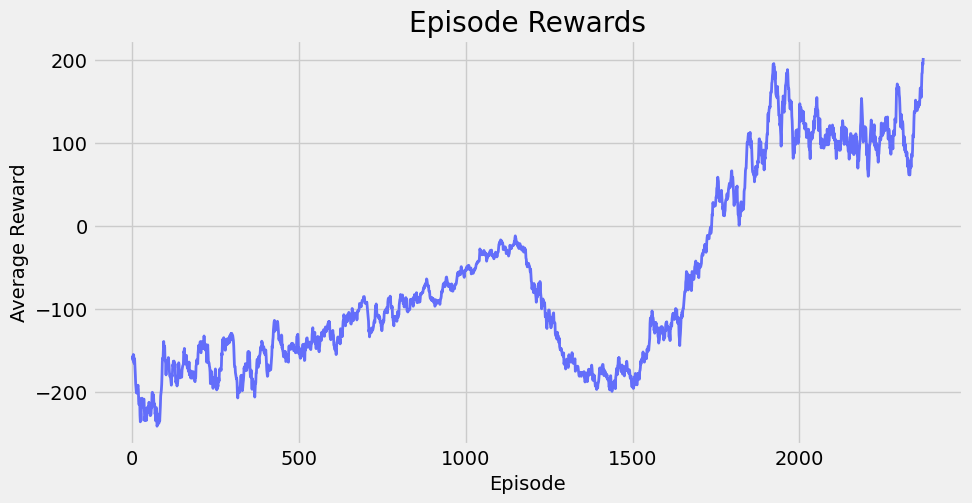

In [9]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

def plot_reward(logs, window_size=20):
    rewards = logs['rewards']
    rolling_means = np.convolve(rewards, np.ones(window_size) / window_size, mode='valid')
    
    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(rolling_means, c = '#636EFA', linewidth=2)
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.grid(True)
    plt.show()

plot_reward(a3c.logs)